In [5]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

from utils.viz_helpers import plot_traj
from utils.metrics import get_ade, get_fde

In [6]:
from utils.dataloader import TrajectoryDataset

train_dataset = TrajectoryDataset("/datasets/argoverse/val_data.npy")
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

test_dataset = TrajectoryDataset("/datasets/argoverse/val_test_data.npy")
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)


(1000, 50, 2)
AB
(200, 50, 2)
AB


In [7]:
import json
# with open("./inp.json") as f:
#     data = json.load(f)

# print(type(data))
# print(data.keys())

In [8]:
# print(np.array(data['x_init']).shape)
# print(np.array(data['y_init']).shape)
# print(np.array(data['v_init']).shape)

ind = [8, 12, 19, 21, 27, 29, 34, 48, 77, 94, 105, 116, 122, 145, 163, 165, 229, 252, 272, 326]
others = [386, 409, 411]

In [9]:
np.arctan(1/-1)

-0.7853981633974483

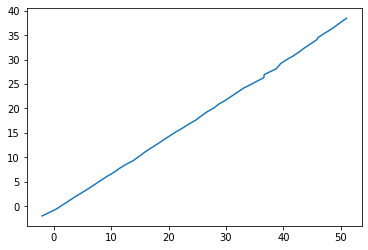

In [10]:
cnt = 0
x_s = []
y_s = []

x_init_s = []
y_init_s = []
vx_init_s = []
vy_init_s = []
psi_init_s = []
psidot_init_s = []

#['x_init', 'y_init', 'v_init', 'psi_init', 'psidot_init', 'x_fin', 'y_fin', 'psi_fin', 'psidot_fin'])

x_fin_s = []
y_fin_s = []
vx_fin_s = []
vy_fin_s = []
psi_fin_s = []
psidot_fin_s = []

dt = 0.1

xs = []
vs = []
psis = []
psidots = []
for i, data in enumerate(train_loader):
    traj_inp, traj_out, b_inp = data
    for ii in range(traj_inp.shape[0]):
#         gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
        if False:
            inp_x = traj_inp[ii,:40:2].detach()
            inp_y = traj_inp[ii,1:40:2].detach()
            gt_x = [traj_out[ii][j] for j in range(len(traj_out[ii])//2)]
            gt_y = [traj_out[ii][j + 30] for j in range(len(traj_out[ii])//2)]
            v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
            v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
            psi = [ np.arctan(v_y[k]/v_x[k]) if v_x[k] > 0 else (np.arctan(v_y[k]/v_x[k]) + np.pi) for k in range(len(v_x))]
            psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
            psi = [i.item() for i in psi]
            psidot = [i.item() for i in psidot]
            x_init = inp_x[19]
            y_init = inp_y[19]
            
#             print(v_x[0], v_y[0], psi[0])
            
            vx_init = v_x[0]
            vy_init = v_y[0]
            
            vx_fin = v_x[len(v_x) - 1]
            vy_fin = v_y[len(v_y) - 1]
            
            psi_init = psi[0]
            psi_fin = psi[len(psi) - 1]
            
            psidot_init = psi[0]
            psidot_fin = psidot[len(psidot) - 1]
            
            x_fin = gt_x[29]
            y_fin = gt_y[29]
            
            
            x_init_s.append([x_init])
            y_init_s.append([y_init])
            
            x_fin_s.append([x_fin])
            y_fin_s.append([y_fin])
            
            vx_init_s.append([vx_init])
            vy_init_s.append([vy_init])
            
            vx_fin_s.append([vx_fin])
            vy_fin_s.append([vy_fin])
            
            psi_init_s.append([psi_init])
            psi_fin_s.append([psi_fin])

            psidot_init_s.append([psidot_init])
            psidot_fin_s.append([psidot_fin])
            
            print(i * 20 + ii)
            plt.plot(gt_x, gt_y, label='gt')
            plt.legend()
            
            xs.append([gt_x, gt_y])
            vs.append([v_x, v_y])
            psis.append([psi])
            psidots.append([psidot])
#             print(arr)
#         plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = cities, avm=None, center=False, inp_len=20 * 2, c_len = 20 * 2 + num_elems * 2, num=30, mode="test", batch_num = i)

x_init_s = [[i[0].item()] for i in x_init_s]
y_init_s = [[i[0].item()] for i in y_init_s]
vx_init_s = [[i[0].item()] for i in vx_init_s]
vy_init_s = [[i[0].item()] for i in vy_init_s]

x_fin_s = [[i[0].item()] for i in x_fin_s]
y_fin_s = [[i[0].item()] for i in y_fin_s]
vx_fin_s = [[i[0].item()] for i in vx_fin_s]
vy_fin_s = [[i[0].item()] for i in vy_fin_s]


dic = {
    'x_init': (x_init_s),
    'y_init': (y_init_s),
    'vx_init': (vx_init_s),
    'vy_init': (vy_init_s),
    'psi_init': (psi_init_s), 
    'psidot_init': (psidot_init_s),
    'x_fin': (x_fin_s),
    'y_fin': (y_fin_s), 
    'psi_fin': (psi_fin_s), 
    'psidot_fin': (psidot_fin_s) 
}

with open("inp.json", "w") as f:
    json.dump(dic, f)
# #['x_init', 'y_init', 'v_init', 'psi_init', 'psidot_init', 'x_fin', 'y_fin', 'psi_fin', 'psidot_fin'])

In [11]:
xs = np.array(xs)
vs = np.array(vs)
psis = np.array(psis)
psidots = np.array(psidots)

print(xs.shape, vs.shape, psis.shape, psidots.shape)

(0,) (0,) (0,) (0,)


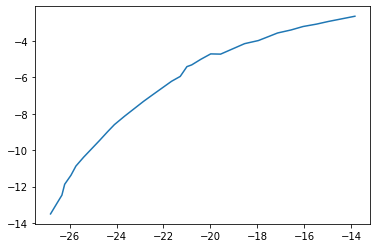

In [13]:
plt.plot(xs[0, 0, :], xs[0, 1, :])

In [14]:
print(xs[0, 0], xs[0, 1])

[-13.83823799 -14.97189598 -15.47706982 -16.04832791 -16.55923466
 -17.13656425 -17.50904194 -17.95404772 -18.54113921 -19.56307642
 -19.98597321 -20.40613318 -20.79619746 -20.99899212 -21.28484361
 -21.6537573  -22.47345256 -22.85034121 -23.31983274 -23.65565937
 -24.09042204 -24.3809927  -24.72035026 -25.40164026 -25.73163982
 -25.94188926 -26.21009358 -26.32806516 -26.54798329 -26.81244999] [ -2.63477483  -2.92284386  -3.06826132  -3.19967563  -3.38875561
  -3.5561565   -3.74703957  -3.97193832  -4.14244385  -4.71805688
  -4.70555993  -5.00251783  -5.3107566   -5.40591082  -5.94426964
  -6.21109174  -6.96574165  -7.3178575   -7.79152114  -8.13000819
  -8.59526943  -8.9851925   -9.46225654 -10.38538597 -10.87481862
 -11.3792107  -11.87608765 -12.47292946 -12.93884264 -13.50542846]


In [15]:
print(vs[0, 0], vs[0, 1])

[-11.33657989  -5.0517384   -5.71258095  -5.10906745  -5.77329591
  -3.72477694  -4.45005777  -5.87091488 -10.21937212  -4.22896791
  -4.20159966  -3.90064286  -2.02794662  -2.8585149   -3.68913687
  -8.1969526   -3.76888654  -4.69491528  -3.35826634  -4.34762671
  -2.90570653  -3.39357567  -6.81289994  -3.29999565  -2.10249439
  -2.68204313  -1.1797158   -2.19918131  -2.64466701] [-2.88069023 -1.45417461 -1.31414316 -1.8907998  -1.67400885 -1.90883073
 -2.24898752 -1.70505531 -5.75613022  0.12496946 -2.969579   -3.0823877
 -0.95154216 -5.38358824 -2.66822103 -7.54649909 -3.52115853 -4.73663636
 -3.38487045 -4.65261248 -3.89923071 -4.77064039 -9.23129426 -4.89432654
 -5.04392076 -4.96876948 -5.96841813 -4.65913178 -5.66585826]


In [16]:
print(np.arctan(vs[0,1,0]/vs[0,0,0]) + np.pi)
# print(psis)

3.390431811549459


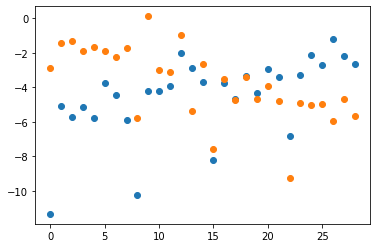

In [17]:
plt.scatter([i for i in range(len(vs[0][0]))] , vs[0, 0, :])
plt.scatter([i for i in range(len(vs[0][0]))] , vs[0, 1, :])

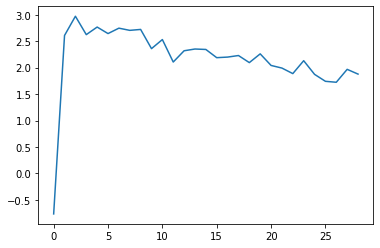

In [18]:
plt.plot([i for i in range(len(psi))] , psi)
# plt.plot([i for i in range(len(psi))], [    for k in range(len())])
# print(np.array(psi).shape)

In [19]:
np.save("pos_data.npy", np.array(xs))
np.save("vel_data.npy", np.array(xs))
np.save("psi_data.npy", np.array(psis))
np.save("psidot_data.npy", np.array(psidots))
print(np.array(psis).shape)
# plt.plot(arr[:, 0], arr[ :, 1])

(20, 1, 29)


In [20]:
with open("./tempinp.json") as f:
    rdata = json.load(f)
    
print(rdata.keys())
print(np.array(rdata['psidot_init']).shape)
print(dic.keys())
print(np.array(dic['psidot_init']).shape)

dict_keys(['x_init', 'y_init', 'v_init', 'psi_init', 'psidot_init', 'x_fin', 'y_fin', 'psi_fin', 'psidot_fin'])
(20, 1)
dict_keys(['x_init', 'y_init', 'vx_init', 'vy_init', 'psi_init', 'psidot_init', 'x_fin', 'y_fin', 'psi_fin', 'psidot_fin'])
(20, 1)


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [12]:
class OPTNode(AbstractDeclarativeNode):
    def __init__(self, rho_eq=1.0, rho_goal=1.0, rho_nonhol=1.0, rho_psi=1.0, maxiter=500, weight_smoothness=5.0, weight_smoothness_psi=5.0, t_fin=8.0, num=16):
        super().__init__()
        self.rho_eq = rho_eq
        self.rho_goal = rho_goal
        self.rho_nonhol = rho_nonhol
        self.rho_psi = rho_psi
        self.maxiter = maxiter
        self.weight_smoothness = weight_smoothness
        self.weight_smoothness_psi = weight_smoothness_psi

        self.t_fin = t_fin
        self.num = num
        self.t = self.t_fin / self.num

        #self.num_batch = 10
        
        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        
        self.cost_smoothness = self.weight_smoothness * np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_psi = self.weight_smoothness_psi * np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)

        self.A_eq = np.vstack((self.P[0], self.P[-1]))
        self.A_eq_psi = np.vstack((self.P[0], self.Pdot[0], self.P[-1], self.Pdot[-1]))
        
        self.P = torch.tensor(self.P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(self.Pdot, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(self.Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(self.A_eq, dtype=torch.double).to(device)        
        self.A_eq_psi = torch.tensor(self.A_eq_psi, dtype=torch.double).to(device)
        self.cost_smoothness = torch.tensor(self.cost_smoothness, dtype=torch.double).to(device)
        self.cost_smoothness_psi = torch.tensor(self.cost_smoothness_psi, dtype=torch.double).to(device)
        self.lincost_smoothness_psi = torch.tensor(self.lincost_smoothness_psi, dtype=torch.double).to(device)
        
        self.A_nonhol = self.Pdot
        self.A_psi = self.P
    
    def compute_x(self, lamda_x, lamda_y, v, psi, b_eq_x, b_eq_y):
        b_nonhol_x = v * torch.cos(psi)
        b_nonhol_y = v * torch.sin(psi)
    
        cost = self.cost_smoothness + self.rho_nonhol * torch.matmul(self.A_nonhol.T, self.A_nonhol) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)
        lincost_x = -lamda_x - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_x.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_x.T).T
        lincost_y = -lamda_y - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_y.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_y.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_x = torch.matmul(-cost_inv, lincost_x.T).T
        sol_y = torch.matmul(-cost_inv, lincost_y.T).T

        x = torch.matmul(self.P, sol_x.T).T
        xdot = torch.matmul(self.Pdot, sol_x.T).T

        y = torch.matmul(self.P, sol_y.T).T
        ydot = torch.matmul(self.Pdot, sol_y.T).T
         
        return sol_x, sol_y, x, xdot, y, ydot
    
    def compute_psi(self, psi, lamda_psi, psi_temp, b_eq_psi):
        cost = self.cost_smoothness_psi + self.rho_psi * torch.matmul(self.A_psi.T, self.A_psi) + self.rho_eq * torch.matmul(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, psi_temp.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, b_eq_psi.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_psi = torch.matmul(-cost_inv, lincost_psi.T).T

        psi = torch.matmul(self.P, sol_psi.T).T

        res_psi = torch.matmul(self.A_psi, sol_psi.T).T - psi_temp
        res_eq_psi = torch.matmul(self.A_eq_psi, sol_psi.T).T - b_eq_psi

        lamda_psi = lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, res_psi.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, res_eq_psi.T).T

        return sol_psi, np.linalg.norm(res_psi), np.linalg.norm(res_eq_psi), psi, lamda_psi

    
    def solve(self, fixed_params, variable_params):
        batch_size, _ = fixed_params.size()
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin, psidot_fin = torch.chunk(variable_params, 4, dim=1)
        
        b_eq_x = torch.cat((x_init, x_fin), dim=1)
        b_eq_y = torch.cat((y_init, y_fin), dim=1)
        b_eq_psi = torch.cat((psi_init, psidot_init, psi_fin, psidot_fin), dim=1)
        
        lamda_x = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        lamda_y = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        lamda_psi = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        
        v = torch.ones(batch_size, self.num, dtype=torch.double).to(device) * v_init
        psi = torch.ones(batch_size, self.num, dtype=torch.double).to(device) * psi_init
        xdot = v * torch.cos(psi)
        ydot = v * torch.sin(psi)
        
        for i in range(0, self.maxiter):
            psi_temp = torch.atan2(ydot, xdot)
            c_psi, _, _, psi, lamda_psi = self.compute_psi(psi, lamda_psi, psi_temp, b_eq_psi)
            c_x, c_y, x, xdot, y, ydot = self.compute_x(lamda_x, lamda_y, v, psi, b_eq_x, b_eq_y)
            
            v = torch.sqrt(xdot ** 2 + ydot ** 2)
            #v[:, 0] = v_init[:, 0]

            res_eq_x = torch.matmul(self.A_eq, c_x.T).T - b_eq_x
            res_nonhol_x = xdot - v * torch.cos(psi)

            res_eq_y = torch.matmul(self.A_eq, c_y.T).T - b_eq_y
            res_nonhol_y = ydot - v * torch.sin(psi)

            lamda_x = lamda_x - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_x.T).T
            lamda_y = lamda_y - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_y.T).T
                    
        
        primal_sol = torch.hstack((c_x, c_y, c_psi, v))
        return primal_sol, None
    
    def objective(self, fixed_params, variable_params, y):
        c_x = y[:, :self.nvar]
        c_y = y[:, self.nvar:2*self.nvar]
        c_psi = y[:, 2*self.nvar:3*self.nvar]
        v = y[:, 3*self.nvar:]
        
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin, psidot_fin = torch.chunk(variable_params, 4, dim=1)
        
        x = torch.matmul(self.P, c_x.T).T
        y = torch.matmul(self.P, c_y.T).T
        psi = torch.matmul(self.P, c_psi.T).T
        xdot = torch.matmul(self.Pdot, c_x.T).T
        ydot = torch.matmul(self.Pdot, c_y.T).T
        psidot = torch.matmul(self.Pdot, c_psi.T).T
        xddot = torch.matmul(self.Pddot, c_x.T).T
        yddot = torch.matmul(self.Pddot, c_y.T).T
        psiddot = torch.matmul(self.Pddot, c_psi.T).T
        
        cost_nonhol = 0.5*self.rho_nonhol*torch.sum((xdot - v*torch.cos(psi)) ** 2, 1) + 0.5*self.rho_nonhol*torch.sum((ydot - v*torch.sin(psi)) ** 2, 1)
        cost_pos = 0.5*self.rho_eq*(torch.sum((x[:, -1] - x_fin) ** 2, 1) + torch.sum((y[:, -1] - y_fin) ** 2, 1) + torch.sum((x[:, 0] - x_init) ** 2, 1) + torch.sum((y[:, 0] - y_init) ** 2, 1))
        cost_psi = 0.5*self.rho_eq*(torch.sum((psi[:, -1] - psi_fin) ** 2, 1) + torch.sum((psi[:, 0] - psi_init) ** 2, 1) + 
                                    torch.sum((psidot[:, -1] - psidot_fin) ** 2, 1) + torch.sum((psidot[:, 0] - psidot_init) ** 2, 1))
        #cost_v = 0.5*self.rho_eq*torch.sum((v[:, 0] - v_init) ** 2, 1)
        
        cost_smoothness = 0.5*self.weight_smoothness*(torch.sum(xddot**2, 1) + torch.sum(yddot**2, 1)) + 0.5*self.weight_smoothness_psi*torch.sum(psiddot**2, 1)
        return cost_nonhol + cost_pos + cost_psi + cost_smoothness #+ cost_v

In [14]:
class DeclarativeFunction(torch.autograd.Function):
    """Generic declarative autograd function.
    Defines the forward and backward functions. Saves all inputs and outputs,
    which may be memory-inefficient for the specific problem.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    """
    @staticmethod
    def forward(ctx, problem, *inputs):
        output, solve_ctx = torch.no_grad()(problem.solve)(*inputs)
        ctx.save_for_backward(output, *inputs)
        ctx.problem = problem
        ctx.solve_ctx = solve_ctx
        return output.clone()

    @staticmethod
    def backward(ctx, grad_output):
        output, *inputs = ctx.saved_tensors
        problem = ctx.problem
        solve_ctx = ctx.solve_ctx
        output.requires_grad = True
        inputs = tuple(inputs)
        grad_inputs = problem.gradient(*inputs, y=output, v=grad_output,
            ctx=solve_ctx)
        return (None, *grad_inputs)

In [15]:
class DeclarativeLayer(torch.nn.Module):
    """Generic declarative layer.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    Usage:
        problem = <derived class of *DeclarativeNode>
        declarative_layer = DeclarativeLayer(problem)
        y = declarative_layer(x1, x2, ...)
    """
    def __init__(self, problem):
        super(DeclarativeLayer, self).__init__()
        self.problem = problem
        
    def forward(self, *inputs):
        return DeclarativeFunction.apply(self.problem, *inputs)

In [16]:
class TrajNet(nn.Module):
    def __init__(self, opt_layer, P, Pdot, input_size=32, hidden_size=64, output_size=4, nvar=11, t_obs=8):
        super(TrajNet, self).__init__()
        self.nvar = nvar
        self.t_obs = t_obs
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(Pdot, dtype=torch.double).to(device)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.opt_layer = opt_layer
        self.activation = nn.ReLU()
        self.mask = torch.tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.double).to(device)
    
    def forward(self, x, fixed_params, var_inp):
        batch_size, _ = x.size()
        out = self.activation(self.linear1(x))
        variable_params = self.linear2(out)
        variable_params = self.mask * var_inp + (1-self.mask) * variable_params
        
        # Run optimization
        sol = self.opt_layer(fixed_params, variable_params)
         
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:2*self.nvar].transpose(0, 1))
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
        out = torch.cat([x_pred, y_pred], dim=1)
        return out

In [8]:
class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None):
        self.data = np.load(data_path)
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.centerline_dir = centerline_dir
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
        
        vx_traj = traj[:, 2]
        vy_traj = traj[:, 3]
        psi_traj = traj[:, 4]
        psidot_traj = traj[:, 5]

        v_x = [ (x_traj[k + 1] - x_traj[k])/self.dt  for k in range(len(x_traj) - 1)]
        v_y = [ (y_traj[k + 1] - y_traj[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan(v_y[k]/v_x[k]) if v_x[k] > 0 else (np.arctan(v_y[k]/v_x[k]) + np.pi) for k in range(len(v_x))]
        psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
        psi = [i.item() for i in psi]
        psidot = [i.item() for i in psidot]        
        psi_traj = np.pi * psi_traj / 180.0
        psidot_traj = np.pi * psidot_traj / 180.0
                
        x_traj = x_traj - x_traj[0]
        y_traj = y_traj - y_traj[0]
                
        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        psi_fut = psi_traj[self.t_obs:]
        psidot_fut = psidot_traj[self.t_obs:]
        
        vx_beg = vx_traj[self.t_obs-1]
        vy_beg = vy_traj[self.t_obs-1]
        
        vx_beg_prev = vx_traj[self.t_obs-2]
        vy_beg_prev = vy_traj[self.t_obs-2]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt
        
        vx_fin = vx_traj[2*self.t_obs-1]
        vy_fin = vy_traj[2*self.t_obs-1]
        
        vx_fin_prev = vx_traj[2*self.t_obs-2]
        vy_fin_prev = vy_traj[2*self.t_obs-2]
        
        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt
        
        traj_inp = np.dstack((x_inp, y_inp)).flatten()        
        if self.centerline_dir is not None:
            cs = np.load(self.centerline_dir)[idx][self.t_obs:]
            data = np.load(self.data_path)

            
            c_x = cs[:, 0]
            
            c_y = cs[:, 1]
            c_x -= data[idx][0,0]
            c_y -= data[idx][0,1]
            c_x -= c_x[0]
            c_y -= c_y[0]
            c_x += x_inp[-1]
            c_y += y_inp[-1]
        
#             c_y += y_inp[-1] + 2
            c_inp = np.dstack((c_x, c_y)).flatten()
            traj_inp = np.hstack((traj_inp, c_inp))
            
        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
        traj_out = np.hstack((x_fut, y_fut)).flatten()
        
        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1], psidot_fut[-1]])
        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(fixed_params), torch.tensor(var_inp)

In [22]:
train_dataset = ArgoverseDataset("/datasets/argoverse/val_data.npy", centerline_dir="/datasets/argoverse/val_centerlines.npy", t_obs=30, dt=0.1)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

test_dataset = ArgoverseDataset("/datasets/argoverse/val_test_data.npy", centerline_dir="/datasets/argoverse/val_test_centerlines.npy", t_obs=30, dt=0.1)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)


NameError: name 'ArgoverseDataset' is not defined

In [17]:
# train_dataset = TrajectoryDataset("/datasets/argoverse/carla_train.npy", centerline_dir="/datasets/argoverse/carla_train_centerlines.npy")
# train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

In [19]:
# test_dataset = TrajectoryDataset("/datasets/argoverse/carla_test.npy", centerline_dir="/datasets/argoverse/carla_test_centerlines.npy")
# test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)

In [21]:
offsets_train = np.load("/datasets/argoverse/val_offsets.npy")
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traj(cnt, traj_inp, traj_out, traj_pred, obs, batch_num=0, num = 30, offsets = [], cities = [], avm = None, center = True, mode = "train", inp_len=40, c_len=70):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.detach().numpy()
    
    lane_centerlines = []
    ind = batch_num * 20 + cnt

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Get lane centerlines which lie within the range of trajectories
    ox = offsets[ind][0] + 2
    oy = offsets[ind][1] + 2
    ox = 0
    oy = 0
    if avm is not None:
        city = cities[ind]
        ox = offsets[ind][0] + 2
        oy = offsets[ind][1] + 2
        x_max = np.max(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        x_min = np.min(np.concatenate((traj_inp[:inp_len:2], traj_out[:num], traj_pred[:num]), axis=0)) + ox
        y_max = np.max(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        y_min = np.min(np.concatenate((traj_inp[1:inp_len:2], traj_out[num:], traj_pred[num:]), axis=0)) + oy
        
        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline

            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            if True:
                ax.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

    ax.scatter(traj_inp[:inp_len:2] + ox, traj_inp[1:inp_len:2] + oy, color='blue', label='Inp traj')
    ax.scatter(traj_out[:num] + ox, traj_out[num:] + oy, color='orange', label='GT')
    ax.scatter(traj_pred[:num] + ox, traj_pred[num:] + oy, color='green', label='Pred')

    if center:
        ax.plot(traj_inp[inp_len:c_len:2] + ox , traj_inp[inp_len + 1:c_len:2] + oy, color='black',label='primary-centerline')
    
    ax.legend()
    ax.set_xlim([-50,50])
    ax.set_ylim([-50,50])    
    if mode == "train":
        plt.savefig('./results/{}.png'.format(cnt))
    else:
        plt.savefig('./results/{}.png'.format(batch_num * 20 + cnt))
    plt.close()


In [32]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
    torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
    print(traj_inp.size(), traj_out.size(), fixed_params.size, var_inp.size)
    ade = []
    fde = []
    out = model(traj_inp, fixed_params, var_inp)    
#     plt.scatter(traj_inp[0][:32:2], traj_inp[0][1:32:2])
#     plt.scatter(traj_inp[0][32:96:2], traj_inp[0][33:96:2])
    for ii in range(1):
        gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
        pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
        ade.append(get_ade(np.array(pred), np.array(gt)))
        fde.append(get_fde(np.array(pred), np.array(gt)))
        plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=True, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num)
    
#     print(fixed_params, var_inp)
    break

torch.Size([20, 64]) torch.Size([20, 32]) <built-in method size of Tensor object at 0x7fc3073e5300> <built-in method size of Tensor object at 0x7fc3073e5400>


In [33]:
problem = OPTNode()
opt_layer = DeclarativeLayer(problem)

model = TrajNet(opt_layer, problem.P, problem.Pdot, input_size=64)
model = model.double()
model = model.to(device)

In [34]:
out = model(traj_inp, fixed_params, var_inp)
out.shape

torch.Size([20, 32])

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [36]:
num = 16
num_elems = 16

In [45]:
epoch_train_loss = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []    
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)

        ade = []
        fde = []            
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=True, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="train", batch_num=batch_num)
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))
    
        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))
    
    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    torch.save(model.state_dict(), "./checkpoints/final.ckpt")
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

Epoch: 0, Batch: 0, Loss: 3.6875044780759567
ADE: 2.231018939248687 FDE: 2.98978541092142
Epoch: 0, Batch: 10, Loss: 2.1793500618931385
ADE: 1.6428823768750784 FDE: 1.785141094435339
Epoch: 0, Mean Loss: 2.7416247192702796
Mean ADE: 1.808391176643898 Mean FDE: 1.9113738755656056
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 2.2350999843840826
ADE: 1.5931155500211154 FDE: 1.721040194841882
Epoch: 1, Batch: 10, Loss: 2.092787812789408
ADE: 1.6162989695885481 FDE: 1.7868217152891226
Epoch: 1, Mean Loss: 2.8558451986637188
Mean ADE: 1.8357353927214948 Mean FDE: 1.9538115143824837
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 2.465809966300967
ADE: 1.657140527856987 FDE: 1.8220169264000834


KeyboardInterrupt: 

In [46]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    mean_ade = []
    mean_fde = []     
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)
        
        ade = []
        fde = []        
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_test, cities = [], avm=None, center=True, inp_len=num * 2, c_len = num * 2 + num * 2, num=num, mode="test", batch_num=batch_num)

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))

Batch: 0, Loss: 2.272251315915624
Batch: 1, Loss: 2.2690870221839683
Batch: 2, Loss: 1.9787803100264583
Batch: 3, Loss: 3.2117938502689656
Batch: 4, Loss: 2.390085830908581
Batch: 5, Loss: 2.6413616257680106
Batch: 6, Loss: 3.222393242925834
Batch: 7, Loss: 2.2955828059614936
Batch: 8, Loss: 2.475143422844444
Batch: 9, Loss: 3.3694734975766636
Epoch Mean Test Loss: 2.6125952924380043
Mean ADE: 1.7750787725301553 Mean FDE: 1.9918675656775726
